In [1]:
! pip install torch torchvision transformers tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from transformers import MobileViTForImageClassification, MobileViTImageProcessor
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# dataset - fashion_mnist
def load_fashion_mnist():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
    val_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

    return train_dataset, val_dataset

In [4]:
# train function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader, desc="Training"):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        inputs = inputs.repeat(1, 3, 1, 1)

        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(train_loader)
    return average_loss, accuracy

# eval function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            inputs = inputs.repeat(1, 3, 1, 1)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = total_loss / len(val_loader)
    return average_loss, accuracy

In [6]:
# mapping 1000 classes to 10 classes
def init_model():
    model = MobileViTForImageClassification.from_pretrained( "apple/mobilevit-small", num_labels=10, ignore_mismatched_sizes=True )
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, 10)
    return model.to(device)

def main():
    # Hyperparameters
    batch_size = 32
    num_epochs = 2
    learning_rate = 1e-4

    # Load dataset
    train_dataset, val_dataset = load_fashion_mnist()

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = init_model()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print()

    # Save the trained model
    torch.save(model.state_dict(), "mobilevit_fashion_mnist.pth")
    print("Training completed. Model saved as 'mobilevit_fashion_mnist.pth'")

if __name__ == "__main__":
    main()

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Epoch 1/2:
Train Loss: 0.4111, Train Acc: 87.77%
Val Loss: 0.2284, Val Acc: 91.78%



Evaluating: 100%|██████████| 313/313 [00:30<00:00, 10.11it/s]


Epoch 2/2:
Train Loss: 0.2041, Train Acc: 92.89%
Val Loss: 0.1889, Val Acc: 93.54%

Training completed. Model saved as 'mobilevit_fashion_mnist.pth'


In [7]:
! pip install matplotlib

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


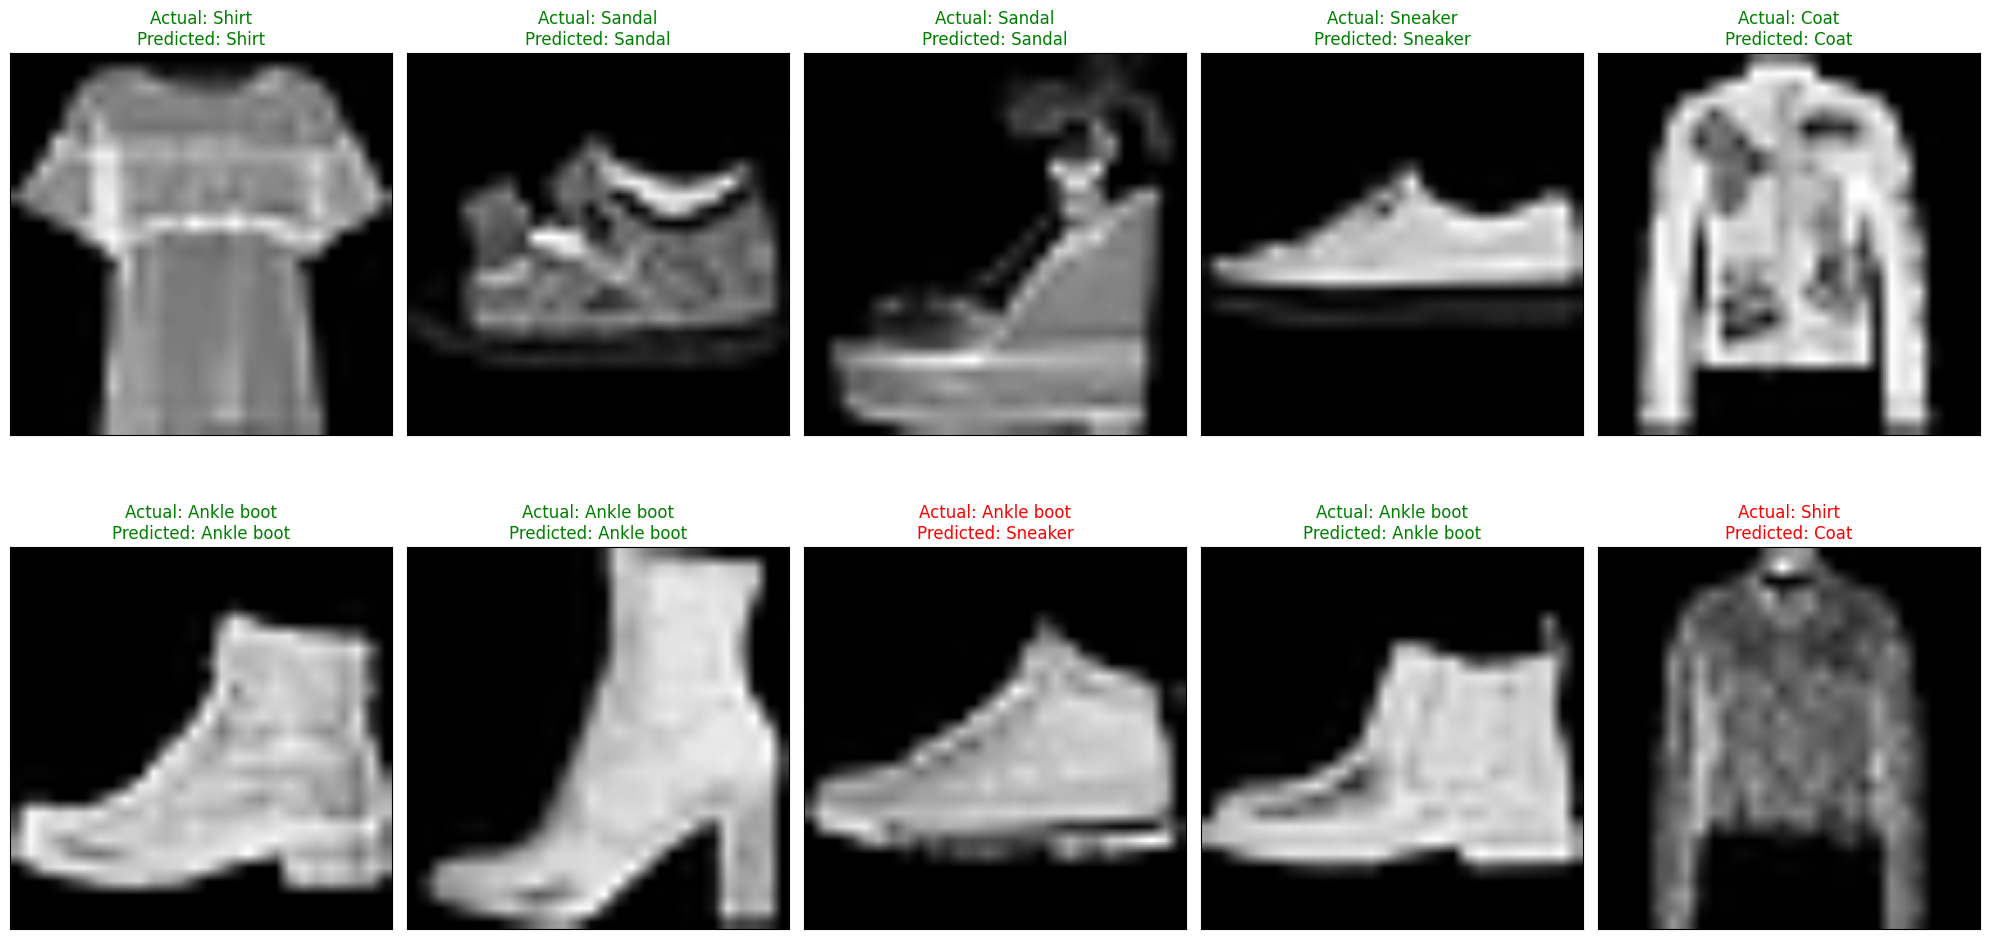

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torchvision.datasets import FashionMNIST

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = init_model()
model.load_state_dict(torch.load('mobilevit_fashion_mnist.pth'))
model.eval()
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def get_prediction(image):
    image = image.unsqueeze(0).repeat(1, 3, 1, 1).to(device)  # Add batch dimension and repeat to 3 channels
    with torch.no_grad():
        outputs = model(image)
    _, predicted = torch.max(outputs.logits, 1)
    return predicted.item()

num_images = 10
fig = plt.figure(figsize=(20, 20))
for i in range(num_images):
    idx = np.random.randint(len(test_dataset))
    img, label = test_dataset[idx]
    pred = get_prediction(img)
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    img = img.squeeze().numpy()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Actual: {class_names[label]}\nPredicted: {class_names[pred]}",
                 color=("green" if pred == label else "red"))

plt.tight_layout()
plt.show()